# Data Preprocessing Notes for Cascadia
Author: Camilla Billari <br> 
Date: 17/01/24

Notes for the data preprocessing that was carried out upon loading Cascadia.

In [11]:
import sys

import h5py
import numpy as np
import pandas as pd
from IPython.display import Image

MAIN_DICT = "/Users/camillagiuliabillari/Desktop/github-repositories/cambridge/earthquake-predictability"
# MAIN_DICT = "/gws/nopw/j04/ai4er/users/cgbill/earthquake-predictability"
sys.path.append(MAIN_DICT)

from utils.dataset import SlowEarthquakeDataset

## Raw Data

Quickly opened it in Matlab for a sanity check:

<!-- <img src="../assets/images/cgb47-notebooks/Datamat.jpg?raw=true" alt="Loaded Data in Matlab Screenshot" width="300"/> -->

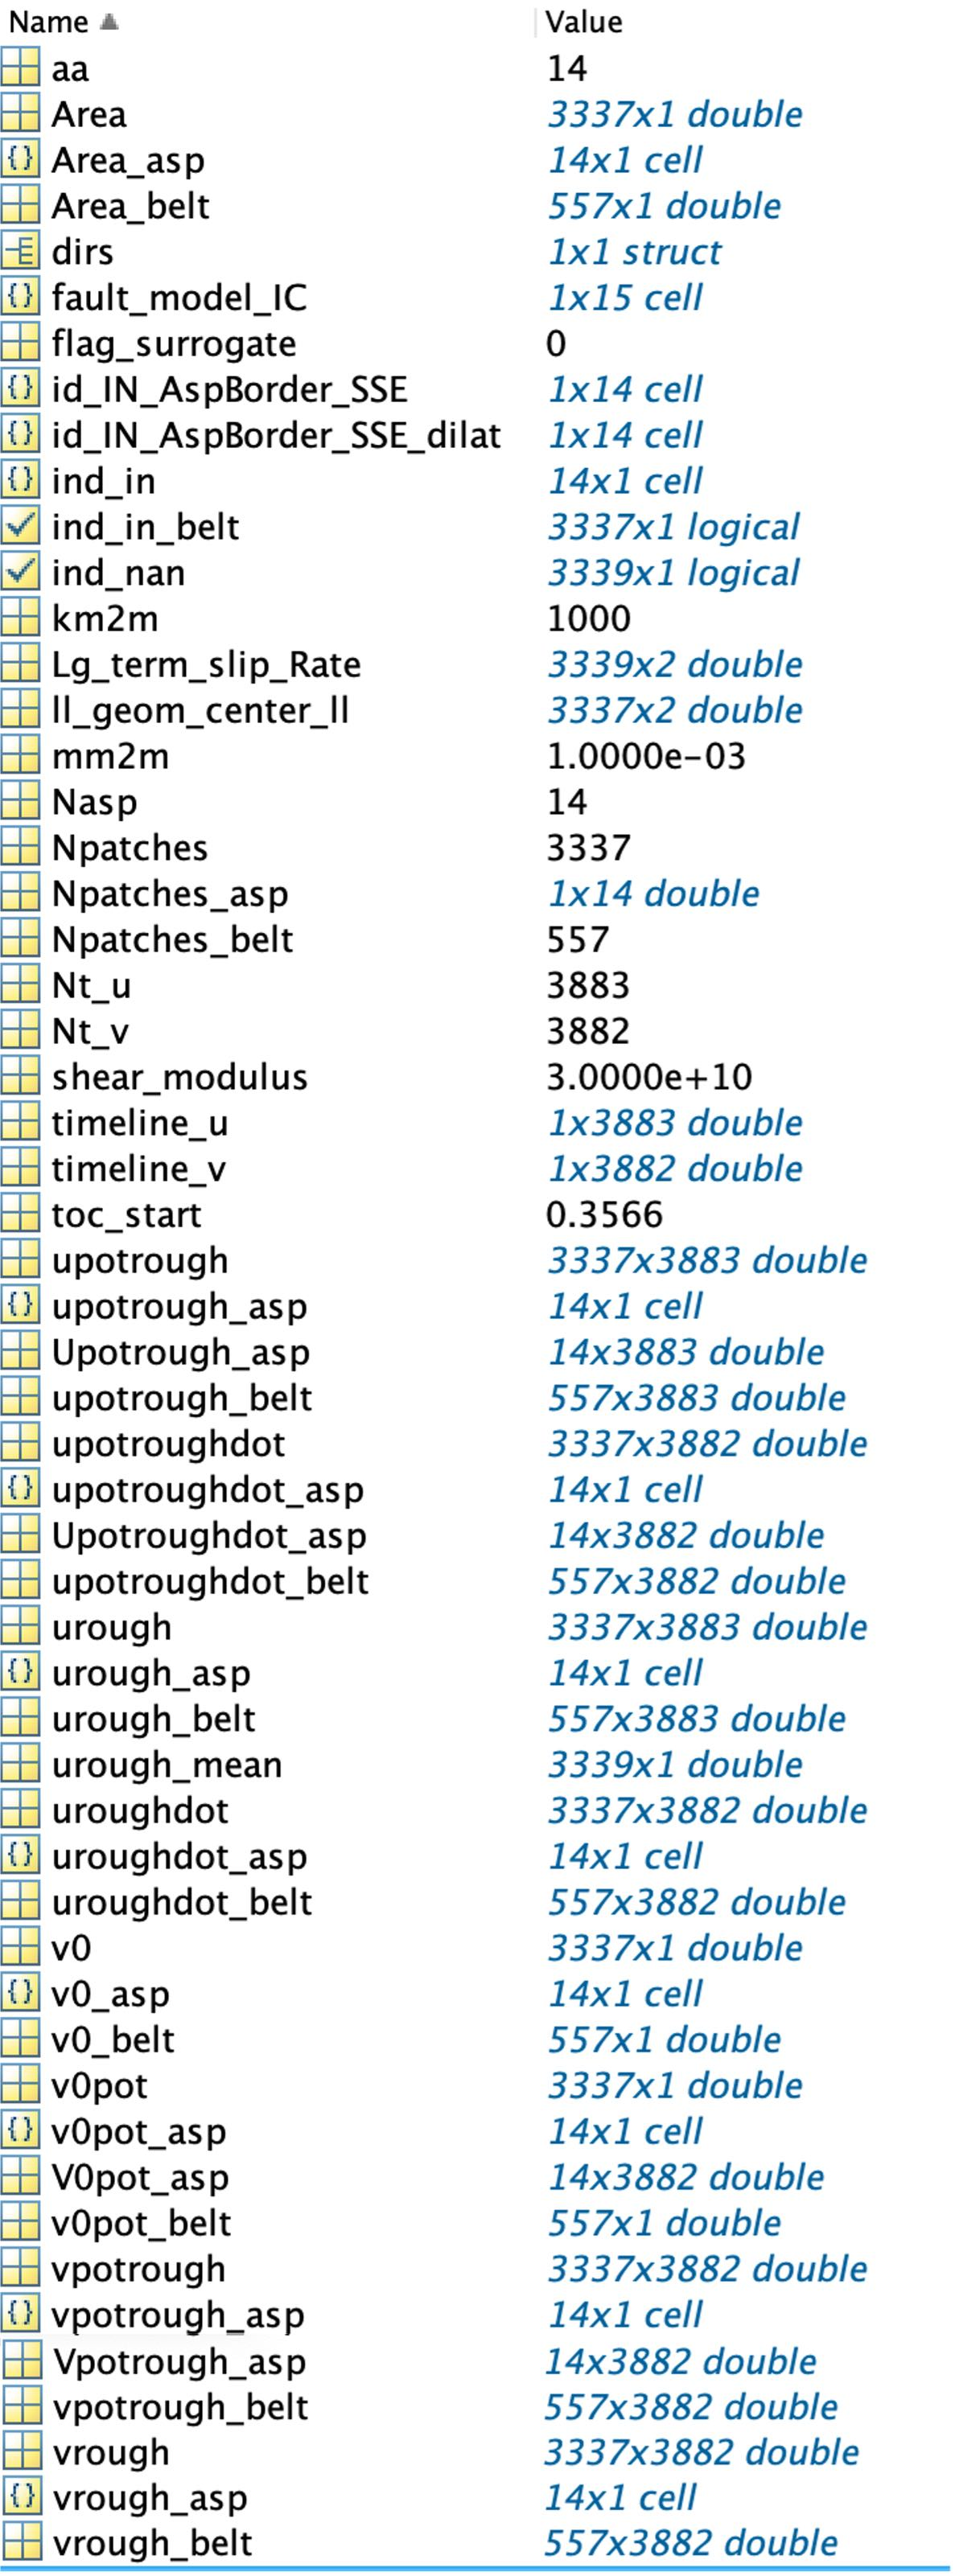

In [12]:
%matplotlib inline
Image("../assets/images/cgb47-notebooks/Datamat.jpg", width=300)

In [2]:
# Directories paths
GTC_DATA_DIR = "/gws/nopw/j04/ai4er/users/cgbill/earthquake-predictability/data/gtc_quakes_data"
SLOWQUAKES_DATA_DIR = f"{GTC_DATA_DIR}/slowquakes"
MICHEL_DATA_DIR = f"{SLOWQUAKES_DATA_DIR}/Micheletal2019a"

# Access the .mat file using h5py which reads it in Hierarchical Data Format (version 5) to preserve references
data_f = h5py.File(
    f"{MICHEL_DATA_DIR}/dynamical_system_variables_rough.mat", "r"
)
keys = list(data_f.keys())
values = list(data_f.values())
print("Column names:", keys)
print("Column types:", values)
print("Number of columns:", len(keys))

Column names: ['#refs#', 'Area', 'Area_asp', 'Area_belt', 'Lg_term_slip_Rate', 'Nasp', 'Npatches', 'Npatches_asp', 'Npatches_belt', 'Nt_u', 'Nt_v', 'Upotrough_asp', 'Upotroughdot_asp', 'V0pot_asp', 'Vpotrough_asp', 'aa', 'dirs', 'fault_model_IC', 'flag_surrogate', 'id_IN_AspBorder_SSE', 'id_IN_AspBorder_SSE_dilat', 'ind_in', 'ind_in_belt', 'ind_nan', 'km2m', 'll_geom_center_ll', 'mm2m', 'shear_modulus', 'timeline_u', 'timeline_v', 'toc_start', 'upotrough', 'upotrough_asp', 'upotrough_belt', 'upotroughdot', 'upotroughdot_asp', 'upotroughdot_belt', 'urough', 'urough_asp', 'urough_belt', 'urough_mean', 'uroughdot', 'uroughdot_asp', 'uroughdot_belt', 'v0', 'v0_asp', 'v0_belt', 'v0pot', 'v0pot_asp', 'v0pot_belt', 'vpotrough', 'vpotrough_asp', 'vpotrough_belt', 'vrough', 'vrough_asp', 'vrough_belt']
Column types: [<HDF5 group "/#refs#" (184 members)>, <HDF5 dataset "Area": shape (1, 3337), type "<f8">, <HDF5 dataset "Area_asp": shape (1, 14), type "|O">, <HDF5 dataset "Area_belt": shape (1, 

In [3]:
# Data loader accesses "upotrough_asp", which is split into the 14 segments, which are triangulated
data_f["upotrough_asp"].shape

(1, 14)

In [ ]:
# Access the time array
t_data = data_f["timeline_u"]
t = t_data[()][
    :, 0
]  # t_data[()] gets entire dataset; then select rows from the first column
dt = t[1] - t[0]  # look at time step in data (1 day)

n_samples = t.shape[0]  # n of samples (time)
n_segments = data_f["upotrough_asp"].shape[
    1
]  # diplacement potency of asperity (rough??)

print("N of t samples: {}, n of segments: {}".format(n_samples, n_segments))

In [ ]:
# Access the triangulated segment 1 and show it in a dataframe
disp_potency_asp = data_f[
    data_f["upotrough_asp"][0][1]
]  # time series of displacement in all 196 triangles in the 1st segment of the asperity

df = pd.DataFrame(disp_potency_asp)
df.head()

### Understanding the pre-processing...

In [ ]:
# Understanding what the data loader is doing...
segment = 1
x_data = data_f[data_f["upotrough_asp"][0][segment]]
upot = dict()

upot["seg" + str(segment)] = x_data[()]  # assign it in the empty dictionary
print("Y:", upot["seg1"])  # -> this is our Y
print("Y shape:", upot["seg1"].shape)  # -> this is our Y

print(
    "X:", np.sum(upot["seg" + str(segment)], axis=1)
)  # -> This will be our X for some reason...

In [ ]:
# I don't get the point of this section...
Upot_raw = np.empty((n_samples, n_segments))  # empty dict for all segments

Upot_raw[:, segment] = np.sum(
    upot["seg" + str(segment)], axis=1
)  # sum over all segments and assign it to the first...
print(
    "Sum at 1: {}".format(Upot_raw[:, 1])
)  # so this literally just has a time series for 1, and has 0 time series for the other segments...
print("At all other indeces...:", Upot_raw[:, 2])
Upot_raw[:, 2] == Upot_raw[:, 3]

In [ ]:
X = -Upot_raw[:, segment]  # ???? why are we doing this
print("X shape:", X.shape)
X = X[..., np.newaxis]
print("New X shape:", X.shape)

In [ ]:
# Y has all the time series for each triangle in segment
Y = upot["seg" + str(segment)]
Y.shape

## Pre-processed Data

#### Useful info from Michel et al. 2019

>"We use daily sampled position time series in the IGS08 reference frame from the Pacific Geodetic Array (PANGA) and the Plate Boundary Observatory (PBO) maintained by UNAVCO and processed by the Nevada Geodetic Laboratory (http://geodesy.unr.edu, last access August 2017). Most of the available continuous GPS (cGPS) stations were deployed in 2007, and we consider the time range that goes from 2007.0 to 2017.632. We use only time series with at most 40% of missing data and we exclude all the stations in the proximity (< 15 km) of volcanoes to avoid contamination by volcanic signals. We also discard station BLYN because of spurious large displacements of unknown origin that were clearly not observed at nearby stations. The final selection includes NGPS = 352 cGPS stations (Fig. 1a). We then refer all the stations to the North America reference frame using the regional block model of Schmaltze et al. (2014). The position time series are then organized in a M × T matrix Xobs, where M = 3 × NGPS is the total number of time series (East, North, and Vertical direction per each station), and T = 3883 is the total number of observed epochs."

In [6]:
# Access Cascadia and output dataframe head - need to ask Pritt about his loader
dataset = SlowEarthquakeDataset(["cascadia"])

ds_exp = dataset["cascadia"]
X, Y, t = ds_exp["X"], ds_exp["Y"], ds_exp["t"]

df = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[ds_exp["hdrs"]["X"], *ds_exp["hdrs"]["Y"], ds_exp["hdrs"]["t"]],
)

df.head()

hello 29
hello
{'t0': 2000.0, 'tend': 2030.0, 'Nheaders': None, 'dir_data': 'gtc_quakes_data/slowquakes/', 'case_study': 'Micheletal2019a/dynamical_system_variables_rough', 'data_type': 'nature', 'struct_type': None, 'file_format': 'mat', 'downsample_factor': 1, 'vl': 0.04, 'segment': 1, 'obs_unit': 'm$^3$', 'time_unit': 'yr', 'obs_label': '$P$ [m$^3$]', 'time_label': 'Time [yr]'}


,seg_avg,seg_0,seg_1,seg_2,seg_3,seg_4,seg_5,seg_6,seg_7,seg_8,...,seg_187,seg_188,seg_189,seg_190,seg_191,seg_192,seg_193,seg_194,seg_195,time
0,1.510314e+08,87022.678176,-51216.196044,-195371.505863,-252388.298108,372090.056832,290238.755195,271991.646241,218795.685053,87096.609524,...,-714770.112748,-631423.743396,-693599.810348,-7.208255e+05,-739527.228854,-471014.225482,-6.757540e+05,-350155.612260,-517024.526987,2007.000700
1,1.256806e+08,118857.552212,64765.192887,-66943.170211,-125253.475061,510980.726973,375269.217942,323695.517273,312924.577753,-6911.497818,...,-506075.873333,-448764.275644,-391456.474306,-9.886575e+05,-958004.348328,-740390.446945,-8.927657e+05,-466337.939160,-928475.702850,2007.003438
2,1.074901e+08,-113120.619296,-100329.909243,-117236.092138,-63257.566664,87699.655400,15131.208777,-22576.356489,-13975.055467,-177396.925200,...,-421853.932989,-333693.022748,-204519.903296,-7.137062e+05,-715494.785171,-542145.799983,-6.803446e+05,-366915.287037,-572674.592498,2007.006176
3,1.447256e+08,-51897.143096,-61146.543996,-108560.424295,-80686.019435,178525.612880,98101.791008,48849.079713,53199.150697,-139909.026614,...,-655215.504038,-473799.573780,-345621.989210,-9.187762e+05,-927868.499626,-679886.516377,-8.823582e+05,-474262.121982,-695698.483285,2007.008914
4,1.787377e+08,-60139.943735,-118351.239477,-228181.280629,-226276.200039,270908.204014,154758.192851,92016.023222,86065.362414,-174784.005040,...,-916992.338832,-753637.001609,-546489.401328,-1.036981e+06,-934869.092836,-938970.117667,-1.106399e+06,-800182.900760,-897332.083419,2007.011651


## Notes on Pre-processing

### General notes:

* We have sampled 100% of dataset (in the 3883 day time window).
* Downsampling frequency = (Michel et al?)
* Original 56 olumns were: ['#refs#', 'Area', 'Area_asp', 'Area_belt', 'Lg_term_slip_Rate', 'Nasp', 'Npatches', 'Npatches_asp', 'Npatches_belt', 'Nt_u', 'Nt_v', 'Upotrough_asp', 'Upotroughdot_asp', 'V0pot_asp', 'Vpotrough_asp', 'aa', 'dirs', 'fault_model_IC', 'flag_surrogate', 'id_IN_AspBorder_SSE', 'id_IN_AspBorder_SSE_dilat', 'ind_in', 'ind_in_belt', 'ind_nan', 'km2m', 'll_geom_center_ll', 'mm2m', 'shear_modulus', 'timeline_u', 'timeline_v', 'toc_start', 'upotrough', 'upotrough_asp', 'upotrough_belt', 'upotroughdot', 'upotroughdot_asp', 'upotroughdot_belt', 'urough', 'urough_asp', 'urough_belt', 'urough_mean', 'uroughdot', 'uroughdot_asp', 'uroughdot_belt', 'v0', 'v0_asp', 'v0_belt', 'v0pot', 'v0pot_asp', 'v0pot_belt', 'vpotrough', 'vpotrough_asp', 'vpotrough_belt', 'vrough', 'vrough_asp', 'vrough_belt'].
* Loader output columns: [1, 2, ..., 196], where:
    * Each column is a time series for the (rough?) slip displacement potency of each triangle in the chosen segment (1) of the fault asperity.
* Pre-processing steps:
    * Y is not pre-processed, but X is the negative sum of all Y columns... I am very confused.


### Annotated Code

#### Setting Experiment Parameter
From _params.py_: 

```python
elif exp == "cascadia":
        parameters = {
            "t0": 2000.0,           # Starting time window loaded - Note: raw data min = 0
            "tend": 2030.0,         # Ending time window loaded - Note: raw data max = 5285.9
            "Nheaders": None,       # Header that np array starts with in import_data
            "dir_data": "gtc_quakes_data/slowquakes/",
            "case_study": "Micheletal2019a/dynamical_system_variables_rough",
            "data_type": "nature",
            "struct_type": None,
            "file_format": "mat",
            "downsample_factor": 1, # No downsampling (in != 1, no code has been written for it)
            "vl": 40e-3,            # Loading velocity
            "segment": 1,           # Segment in asperity to select
            "obs_unit": r"m$^3$",
            "time_unit": "yr",
        }

        [...] # Assigns new params for obs and time labels with units
```


#### Loading and Pre-processing
Note: load_data() takes in the parameters defined above, loads and processes the data, and outputs it into X, Y, t, dt, vl.

Relevant parts from _load.py_: 

```python
def load_data(exp, dirs, params):

    elif params["data_type"] == "nature":
        [...] # load the file using h5py

        # Select the "upotrough_asp" and "timeline_u" columns in data
        # Note "upotrough_asp" shape = 14x1, with each cell having shape = n x 3883 (n differs per cell)
        # So I would assume all 14 are different time series - are they the neighbouring stations like Adriano was saying?
        upotrough_asp_ref = f.get("upotrough_asp") 
        t_data = f.get("timeline_u")        # shape = 1x3883, observed eppchs
        t = t_data[()][:, 0]                # t_data[()] gets entire dataset; then select rows from the first column

        dt = t[1] - t[0]                    # look at time step in data (1 day)

        n_samples = t.shape[0]              # n of samples
        n_segments = upotrough_asp_ref.shape[1] # diplacement potency of asperity (rough??)

        upot = dict()                       # diplacement potency dict for desired dict
        Upot_raw = np.empty((n_samples, n_segments))    # raw diplacement potency for all segments (though most remain empty?? What is the point of this...)

        # Choose desired triangulated segment of the sperity 
        if params["segment"] is None:
            segment = 0
        else:
            segment = params["segment"]                 # Parameter set at 1 in the loader

        x_data = f[upotrough_asp_ref[0][segment]]       # select the time series for the desired segment
        upot["seg" + str(segment)] = x_data[()]         # assign it in the empty dictionary
        Upot_raw[:, segment] = np.sum(upot["seg" + str(segment)], axis=1) # sum over all triangles... why not average? Why not just access Upotrough_asp instead? - but actually they are different. Questions for Adriano.

        Y = upot["seg" + str(segment)]  # output all 196 triangles as Y time series
        X = -Upot_raw[:, segment]       # why??? why is our X a sum of all Ys...
        X = X[..., np.newaxis]          # reshape from (3883,) to (3883, 1)

        vl = params["vl"]
        [...] #---- Estimate loading velocity from loading displacenment if not present, but in Cascadia vl=40e-3
            
    
    return X, Y, t, dt, vl # note we read the first 3 in as out 6 column dataset [X, Y, t]
```